In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib as tpl
from tqdm import tqdm
import gcmpyo3

plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size']   = 12

In [3]:
PlotSize = (10, 10)

In [4]:
def numpyfy_dict(d):
    for k in d:
        d[k] = np.array(d[k])
    return d

def numpyfy_dict_of_dicts(d):
    for k in d:
        d[k] = numpyfy_dict(d[k])
    return d


In [11]:
# load the data for constant lambda, lambda error and lambda loss

large_alpha_str = '' # either ¨'_large_alpha' or ''

lambda_ = 1.0
const_lambda_input_files = {
    "bootstrap_bootstrap" :f"data/logistic/bootstrap_bootstrap_overlaps{large_alpha_str}_lambda={lambda_}.json",
    "bootstrap_full"      :f"data/logistic/bootstrap_full_overlaps{large_alpha_str}_lambda={lambda_}.json",
    "full_full"           :f"data/logistic/full_full_overlaps{large_alpha_str}_lambda={lambda_}.json",
    "y_resampling"        :f"data/logistic/y_resampling_overlaps{large_alpha_str}_lambda={lambda_}.json",
    "residual_bootstrap"  :f"data/logistic/residual_bootstrap_overlaps{large_alpha_str}_lambda={lambda_}.json",
    "subsampling_subsampling" : f"data/logistic/subsampling_subsampling_overlaps{large_alpha_str}_lambda={lambda_}_p=0.8.json",
    "subsampling_subsampling_2" : f"data/logistic/subsampling_subsampling_overlaps{large_alpha_str}_lambda={lambda_}_p=0.99.json",
}
const_lambda_overlaps = { key : json.load(open(const_lambda_input_files[key], "r")) for key in const_lambda_input_files }
const_lambda_alpha_range = const_lambda_overlaps["full_full"]["alpha"]

const_lambda_overlaps = numpyfy_dict_of_dicts(const_lambda_overlaps)

In [12]:
# compute the variance for Bayes optimal 

const_lambda_overlaps["bayes_optimal"] = {"variance" : []}

for alpha in tqdm(const_lambda_alpha_range):
    m, q, v, _, _, _ = gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(alpha, 0.0, 1.0, "logit", 1e-8, True, False)
    const_lambda_overlaps["bayes_optimal"]["variance"].append(1.0 - q)

100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


---

# Constant $\lambda$

Text(0, 0.5, 'Bias')

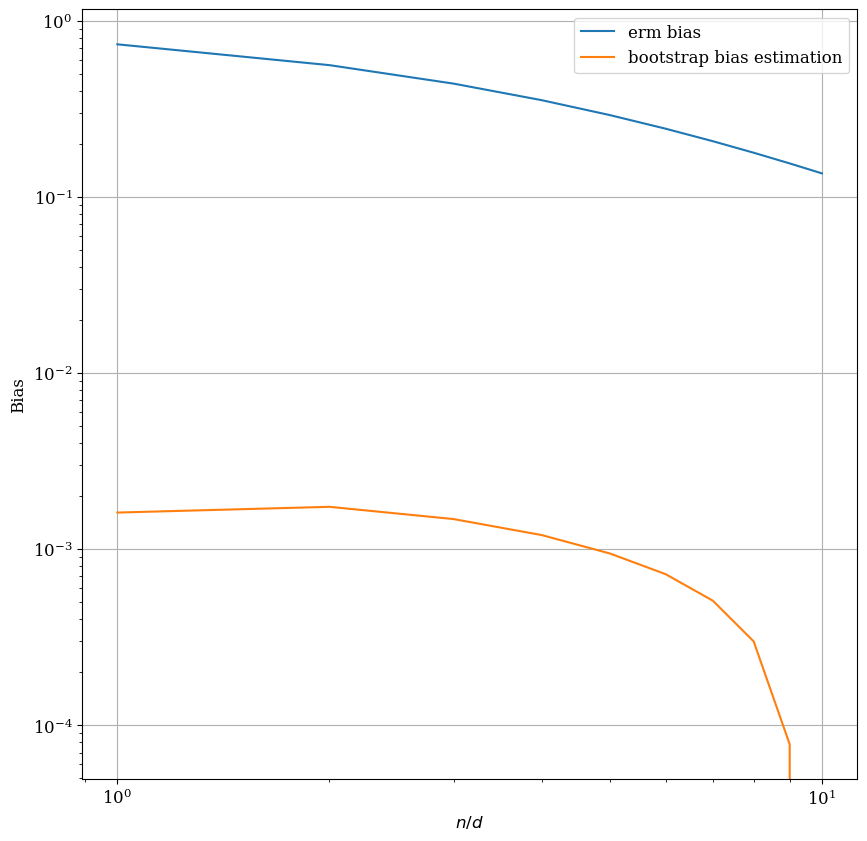

In [13]:
erm_bias            = 1.0 + const_lambda_overlaps["full_full"]["q_off_diag"] - 2 * const_lambda_overlaps["full_full"]["m"]
erm_bias_estimation = const_lambda_overlaps["full_full"]["q_diag"] + const_lambda_overlaps["bootstrap_bootstrap"]["q_off_diag"] - 2 * const_lambda_overlaps["bootstrap_full"]["q_off_diag"]

plt.figure(figsize = PlotSize)

plt.loglog(const_lambda_alpha_range, erm_bias, label="erm bias", )
plt.loglog(const_lambda_alpha_range, erm_bias_estimation, label="bootstrap bias estimation")
plt.yscale("log")

plt.grid()
plt.legend()

plt.xlabel("$n / d$")
plt.ylabel("Bias")

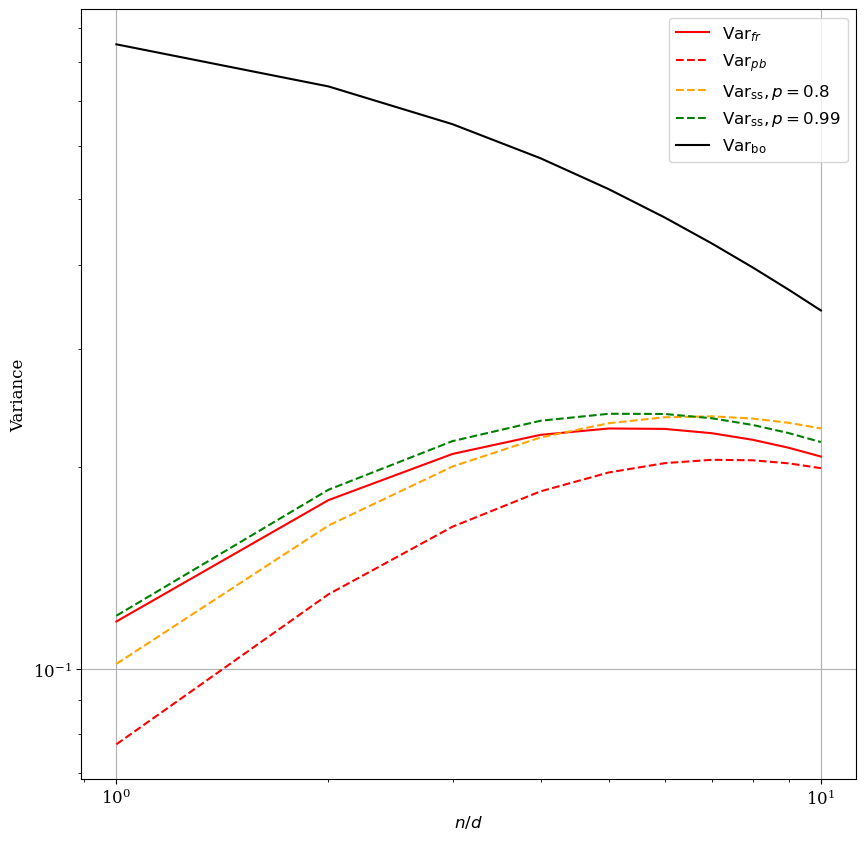

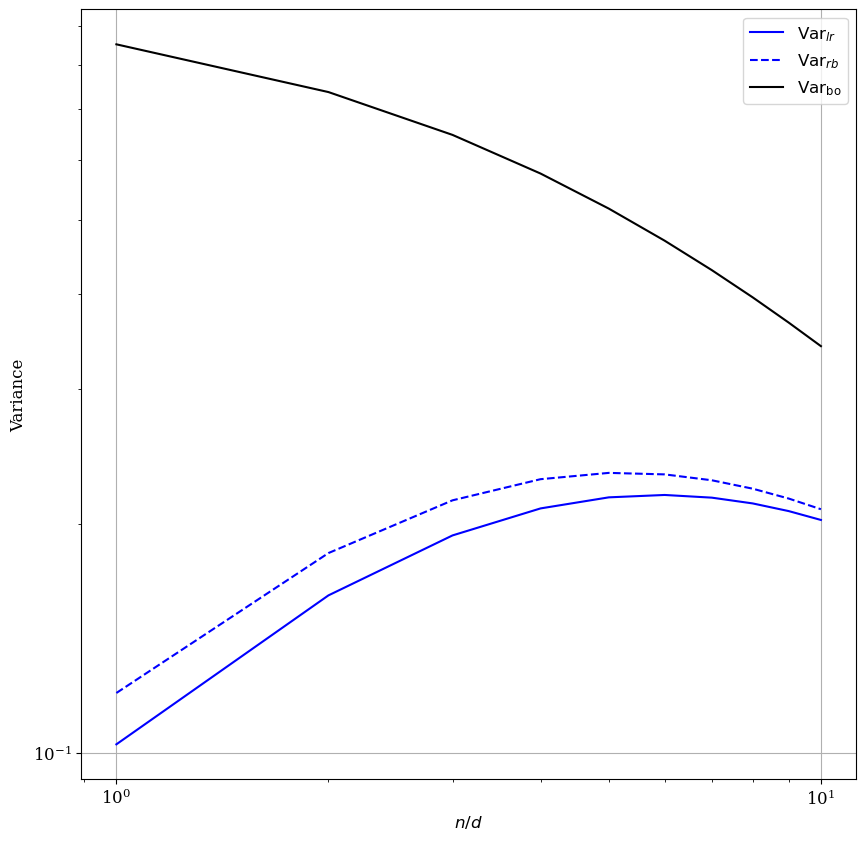

In [14]:
# VARIANCE OF THE RESAMPLING 

p = 0.8
p2 = 0.99

plt.figure(figsize=PlotSize)

const_lambda_overlaps["full_full"]["variance"] = const_lambda_overlaps["full_full"]["q_diag"] - const_lambda_overlaps["full_full"]["q_off_diag"]
const_lambda_overlaps["bootstrap_bootstrap"]["variance"] = const_lambda_overlaps["bootstrap_bootstrap"]["q_diag"] - const_lambda_overlaps["bootstrap_bootstrap"]["q_off_diag"]
const_lambda_overlaps["y_resampling"]["variance"] = const_lambda_overlaps["y_resampling"]["q_diag"] - const_lambda_overlaps["y_resampling"]["q_off_diag"]
const_lambda_overlaps["residual_bootstrap"]["variance"] = const_lambda_overlaps["residual_bootstrap"]["q_diag"] - const_lambda_overlaps["residual_bootstrap"]["q_off_diag"]
const_lambda_overlaps["subsampling_subsampling"]["variance"] = const_lambda_overlaps["subsampling_subsampling"]["q_diag"] - const_lambda_overlaps["subsampling_subsampling"]["q_off_diag"]
const_lambda_overlaps["subsampling_subsampling_2"]["variance"] = const_lambda_overlaps["subsampling_subsampling_2"]["q_diag"] - const_lambda_overlaps["subsampling_subsampling_2"]["q_off_diag"]

plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["full_full"]["variance"], 'r', label="${\\rm Var}_{fr}$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["bootstrap_bootstrap"]["variance"], 'r--', label="${\\rm Var}_{pb}$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["subsampling_subsampling"]["variance"] / (1.0 - p), 'orange', linestyle='--', label="${\\rm Var}_{\\rm ss}, p = 0.8$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["subsampling_subsampling_2"]["variance"] / (1.0 - p2), 'g--', label="${\\rm Var}_{\\rm ss}, p = 0.99$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["bayes_optimal"]["variance"], 'k', label="${\\rm Var}_{\\rm bo}$")

plt.grid()
plt.legend()

plt.xlabel("$n / d$")
plt.ylabel("Variance")

plt.show()

plt.figure(figsize=PlotSize)

plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["y_resampling"]["variance"], 'b', label="${\\rm Var}_{lr}$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["residual_bootstrap"]["variance"], 'b--', label="${\\rm Var}_{rb}$")
plt.loglog(const_lambda_alpha_range, const_lambda_overlaps["bayes_optimal"]["variance"], 'k', label="${\\rm Var}_{\\rm bo}$")

plt.xlabel("$n / d$")
plt.ylabel("Variance")
plt.grid()
plt.legend()

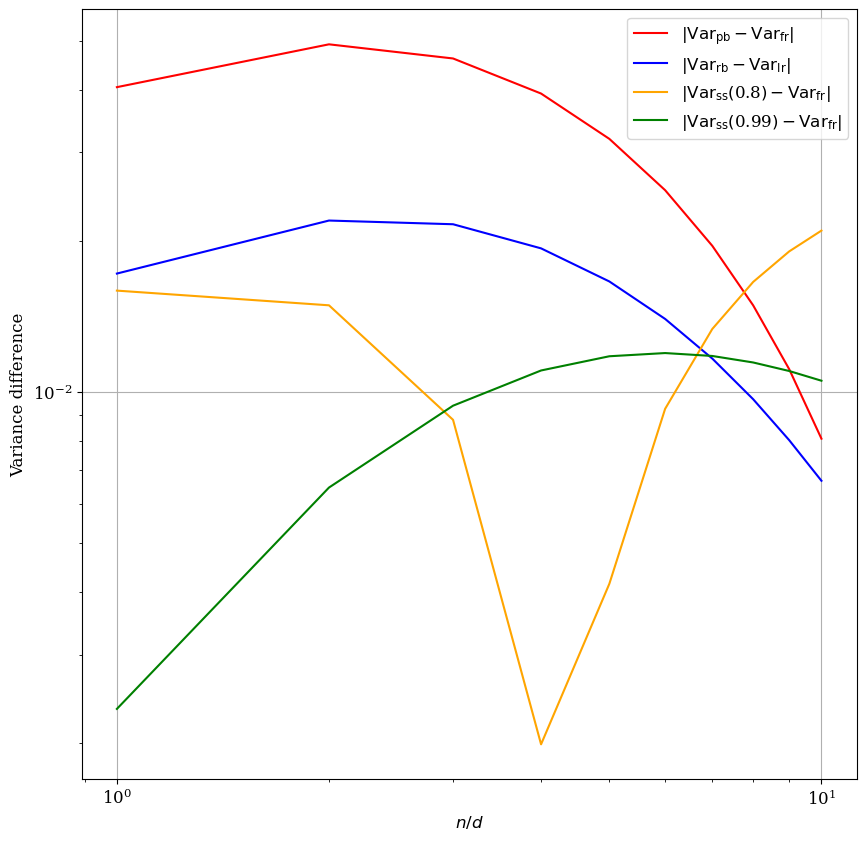

In [18]:
# plot the difference between the variances
plt.figure(figsize=PlotSize)

plt.loglog(const_lambda_alpha_range, np.abs(const_lambda_overlaps["bootstrap_bootstrap"]["variance"] - const_lambda_overlaps["full_full"]["variance"]),                   label = '$| {\\rm Var}_{\\rm pb} - {\\rm Var}_{\\rm fr} |$', c='r')
plt.loglog(const_lambda_alpha_range, np.abs(const_lambda_overlaps["residual_bootstrap"]["variance"] - const_lambda_overlaps["y_resampling"]["variance"]),                 label = '$| {\\rm Var}_{\\rm rb} - {\\rm Var}_{\\rm lr} |$', c='b')
plt.loglog(const_lambda_alpha_range, np.abs(const_lambda_overlaps["subsampling_subsampling"]["variance"]/ (1.0 - p) - const_lambda_overlaps["full_full"]["variance"]),    label = '$| {\\rm Var}_{\\rm ss}($' + f'{p}' + '$) - {\\rm Var}_{\\rm fr} |$', c='orange')
plt.loglog(const_lambda_alpha_range, np.abs(const_lambda_overlaps["subsampling_subsampling_2"]["variance"]/ (1.0 - p2) - const_lambda_overlaps["full_full"]["variance"]), label = '$| {\\rm Var}_{\\rm ss}($' + f'{p2}' + '$) - {\\rm Var}_{\\rm fr}|$', c='green')

plt.grid()
plt.xlabel("$n / d$")
plt.ylabel("Variance difference")
plt.legend()